In [35]:
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra
lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk


from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom
from calc_del_lambda import pdf_from_data
from helpers import mkdir_p
from helpers import bad_spec_detection

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages


def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)


dataPath ='/home/agoga/Documents/nreshk/data/'
setName = '22049/'

obsPath = dataPath + setName+ 'obs/'
flatsPath = dataPath + setName+ 'flats/'


obsDict = dict()
for obFile in os.listdir(obsPath):
    if obFile.endswith(".fits"):
        obsHDu1 = astropy.io.fits.open(obsPath+obFile)
        if(setName.strip('/') not in obsHDu1[0].header['OBJECT']):
            continue
        obsDate = mjd_from_hdu(obsHDu1)
        #print(obFile + ' for mjd: ' + str(obsDate))
        obsDict.update({obsDate:obsHDu1})
#        print(int(obsDate))
        
#print('-------------------------')

flatDict = dict()       
for flFile in os.listdir(flatsPath):
    if flFile.endswith(".fits"):
        flatHDu1 = astropy.io.fits.open(flatsPath+flFile)
        flatDate = mjd_from_hdu(flatHDu1)
        flatDict.update({int(flatDate):flatHDu1})
#        print(int(flatDate))
#print('-------------------------')
#for k in obsDict:
#    print(closestKey(flatDict,int(k)))

res = .01
label =''



#todo fill this to print out in 
bad = []#[58330.3596906,58330.3634695,
      # 58553.7527935,58553.7479017,
      # 58272.4211262,58272.4248934,
      # 58354.2323109,58354.2381758]

   

data = [[],[]]#,[]]
sites = []
for oK in obsDict:
    fK = closestKey(flatDict,oK)
    
    if abs(oK-fK) > 2:
        print('closest for: '+str(oK) +' is '+ str(abs(oK-fK)))
    oHDu = obsDict[oK]
    fHDu = flatDict[fK]
    
    waveGrid = oHDu[7].data
    flat = fHDu[0].data
    spec = oHDu[1].data

    ret = mk_flatolap(waveGrid, flat)
    flatOlap = ret[1]
    lamGrid = ret[0]

    label=str(oK).replace('.','/') 
    #print('label: ' + label)
    #plt.figure()
    #plt.title('mjd: ' + str(oK))

    targOlapf = calc_targOlapf(lamGrid, waveGrid, spec, flatOlap, label)
    #
    
    
    
    out = tmp_find_del_lam(lab[0]/10,lab[1], lamGrid, targOlapf,res)
    dLam = out[0]
    labSpec = out[2]
    
    #bad_spec_detection(lamGrid-dLam, targOlapf)
    
    lamRef = 396.85
    #delta lamda / ref lamda * speed of light
    rv = dLam/ lamRef * sc.c 
    #rv from meters to km/s as desired by hk_windows
    rv = rv/10000
    #print('rv: ' + str(rv))
    
    #find SHK with new offset to lamda grid
    shkRet = calc_shk(lamGrid-dLam, targOlapf, 0, teff=5086)
    shk = shkRet[0]
    windows = shkRet[1]
    print('MJD: ' + str(oK) + ' w/ shk: ' + str(shk))
    
    
    first = label.split("/")[0]
    second = label.split("/")[1]
    mkdir_p("output/"+setName+first+'/')
    np.savez("output/"+setName+first+"/"+ second+"_data", targOlapf=targOlapf,flatOlap=flatOlap, lamGrid=lamGrid, adjLamGrid=lamGrid-dLam,windows=windows)

    
    pdf_from_data(lamGrid, labSpec,lamGrid-dLam, targOlapf, flatOlap,windows, "output/"+setName+first+"/",second,.3)
    
    if(shk < 0):
        continue
    if(oK in bad):
        continue
    data[0].append(mjd_from_hdu(obsDict[oK]))
    data[1].append(shk)
    sites.append(obsDict[oK][0].header['SITEID'])

MJD: 58471.952604 w/ shk: 0.3326412437327161
MJD: 58471.9574956 w/ shk: 0.36840594740158206
MJD: 58497.8457527 w/ shk: 0.2943557372377248
MJD: 58497.8506448 w/ shk: 0.3038786631618282
MJD: 58538.7946656 w/ shk: 0.3273127788521434
MJD: 58538.799557 w/ shk: 0.29756166566837294
MJD: 58655.1802291 w/ shk: 0.3144514083898328
MJD: 58655.1851092 w/ shk: 0.31280101821046313
closest for: 58372.9628576 is 10.96285760000319
MJD: 58372.9628576 w/ shk: 0.3065388979580657
closest for: 58372.9677498 is 10.967749800001911
MJD: 58372.9677498 w/ shk: 0.3076988846060459
MJD: 58394.9053518 w/ shk: 0.2996811442119166
MJD: 58394.9102553 w/ shk: 0.30894578446976606
MJD: 58434.3511998 w/ shk: 0.08592981496679981
MJD: 58434.3561144 w/ shk: 0.3571363351814943
closest for: 58323.3520045 is 2.3520044999968377
MJD: 58323.3520045 w/ shk: 0.3336591641959315
closest for: 58323.3557717 is 2.355771700000332
MJD: 58323.3557717 w/ shk: 0.31326633479175103
closest for: 58331.3384727 is 2.338472700001148
MJD: 58331.3384727

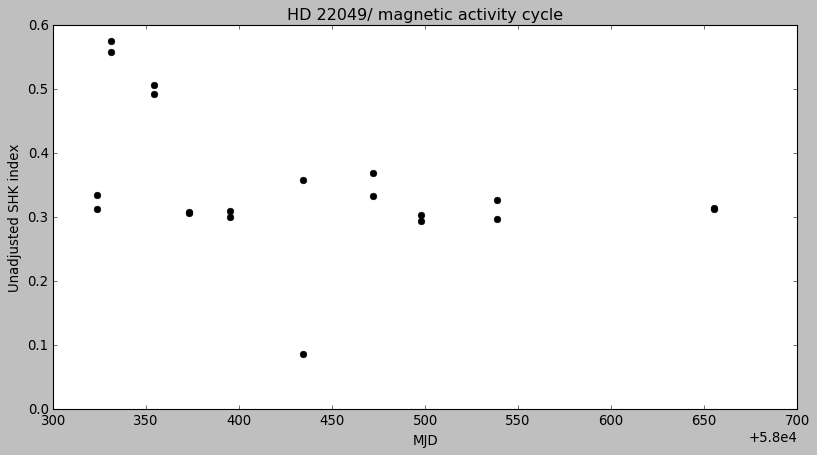

In [37]:

#for i in oldData[0]:
#    data[0].append(i)
#for i in oldData[1]:
#    data[1].append(i)
#for i in oldSites:
#    sites.append(i)
    
shkArray = np.asarray(data)
siteArray = np.asarray(sites)
plt.figure(figsize=(12,6))    
#t= Time(shkArray[0], format='mjd')
#t.format = 'decimalyear'
   
plt.plot(shkArray[0],shkArray[1], 'ko')
plt.title('HD '+setName+' magnetic activity cycle')
plt.xlabel('MJD')
plt.ylabel('Unadjusted SHK index')
plt.savefig('output/'+setName+'shk_time_series.pdf')
plt.show()
plt.close()

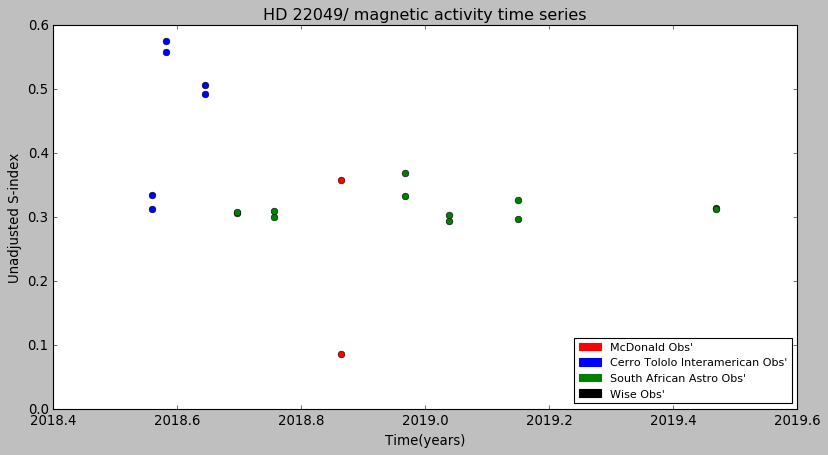

In [38]:
from astropy.time import Time

import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12,6))

newT = shkArray[0][siteArray=='lsc']
newVal = shkArray[1][siteArray=='lsc']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'bo')

newT = shkArray[0][siteArray=='cpt']
newVal = shkArray[1][siteArray=='cpt']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'go')

newT = shkArray[0][siteArray=='elp']
newVal = shkArray[1][siteArray=='elp']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'ro')


newT = shkArray[0][siteArray=='tlv']
newVal = shkArray[1][siteArray=='tlv']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'ko')
#plt.plot(shkArray[0][shkArray[2]=='cpt'],shkArray[1][shkArray[2]=='cpt'], 'go')

rl = mpatches.Patch(color='red', label='McDonald Obs\'')
bl = mpatches.Patch(color='blue', label='Cerro Tololo Interamerican Obs\'')
gl = mpatches.Patch(color='green', label='South African Astro Obs\'')
kl = mpatches.Patch(color='black', label='Wise Obs\'')
#sLeg = mpatches.Patch(color='blue', label='combined s val')
plt.legend(handles=[rl,bl,gl,kl],prop={'size': 10}, loc=4)

plt.style.use('classic')
#plt.rcParams['axes.titlesize'] = 22
ax.ticklabel_format(useOffset=False)
plt.title('HD '+setName+' magnetic activity time series')
plt.xlabel('Time(years)')
plt.ylabel('Unadjusted S-index')
plt.savefig('output/'+setName+setName.strip('/')+'_shk_time_series.pdf')
plt.show()
plt.close()

In [ ]:
pi = sc.pi
p1 = 1.968
a1 = 0.0118
f1 = 6.27

p2 = 1.412
a2 = 0.0102
f2 = 4.51
sList = np.zeros((4,100))
for i in range(0,len(sList[0])):
    t = 2018.5 + (i/100)
    s1 = a1*np.sin(2*pi*(t+f1)/p1) 
    s2 = a2*np.sin(2*pi*(t+f2)/p2) 
    s = s1+s2
    sList[0,i]=t
    sList[1,i]=s1
    sList[2,i]=s2
    sList[3,i]=s
    
shkArray = np.asarray(tmpArray)


from astropy.time import Time
import matplotlib.patches as mpatches

plt.figure(figsize=(16,6))    
#plt.plot(sList[0],sList[1],'g-')
#plt.plot(sList[0],sList[2],'r-')
#plt.plot(sList[0],sList[3],'b-')

    
t= Time(shkArray[0], format='mjd')
t.format = 'decimalyear'
print(t)
plt.plot(t.value,shkArray[1],'ko')#-np.mean(shkArray[1]), 'ko')
plt.title('HD 17051 magnetic activity cycle')
plt.xlabel('Time(years)')
plt.ylabel('S index(unadjusted)')
#shkLeg = mpatches.Patch(color='black', label='shk values')
#magLeg = mpatches.Patch(color='red', label='magnetic')
#rotLeg = mpatches.Patch(color='green', label='rotation')
#sLeg = mpatches.Patch(color='blue', label='combined s val')
#plt.legend(handles=[shkLeg,magLeg,rotLeg,sLeg])
#plt.axhline(linewidth=1, color='k')
plt.savefig('images/shk_adjusted_series.jpg')
plt.show()
plt.close()
